In [3]:
# Load libraries
import torch
import torch.nn as nn

#from res.plot_lib import set_default, show_scatterplot, plot_bases
from matplotlib.pyplot import plot, title, axis

In [4]:
import math
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

In [5]:
model = nn.Sequential(
            nn.Linear(1,10),
            nn.Tanh(),
            nn.Linear(10, 2)
        )

In [6]:
def generate_x(n=10000):
    return (-2*math.pi)*torch.rand(n,1) + 2*math.pi
def generate_y(x, n=10000):
    y1 = torch.cos(x)
    y2 = torch.sin(x)
    y = torch.cat([y1,y2],dim=1)
    return y

In [7]:
x  = generate_x()
y = generate_y(x)

In [8]:
with torch.no_grad():
    out = model(torch.tensor([math.pi]))
    print(out)

tensor([-0.4360, -0.3126])


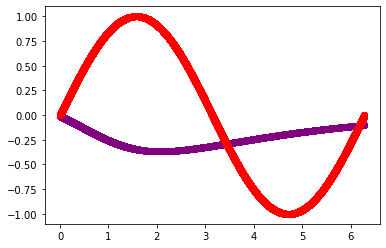

In [9]:
out = model(x)

plt.plot(x, out[:,1].detach().numpy(), 'o', color='purple');
plt.plot(x, np.sin(x), 'o', color='red');

In [10]:
#TODO make the model train so it learns the sin and cos function
optimizer = torch.optim.SGD(model.parameters(),lr=0.005 ,  momentum=0.9)
mse = torch.nn.MSELoss()
bs = 128
print_every=100

for epoch in range(1000):
    total_loss = []
    for i in range(len(x)//bs + 1):
        optimizer.zero_grad()
        input_x1 = x[i*bs:i*bs+bs,:]
        target = y[i*bs:i*bs+bs,:]
        #print(input_x1.shape, target.shape)
        pred = model(input_x1)
        loss = mse(pred, target)
        loss.backward()
        optimizer.step()
        total_loss.append(loss.item())
    if epoch % print_every == 0:
        print(f"epoch: {epoch} Loss: {np.mean(total_loss)}")
        

epoch: 0 Loss: 0.3999551979801323
epoch: 100 Loss: 0.0035139182553025365
epoch: 200 Loss: 0.00199521262982648
epoch: 300 Loss: 0.0013952927112791545
epoch: 400 Loss: 0.0010449080890091726
epoch: 500 Loss: 0.0008207170272104536
epoch: 600 Loss: 0.0006698690853273213
epoch: 700 Loss: 0.000564462120668326
epoch: 800 Loss: 0.00048785729892257177
epoch: 900 Loss: 0.00042975962460792586


In [11]:
def generate_observations(n=100):
    θ =  (-2*math.pi)*torch.rand(n,1) + 2*math.pi# (r1 - r2) * U + r2
    y1 = 2*torch.cos(θ)# 2*[-1,1]
    y2 = 1.5*torch.sin(θ)# 2*[-1,1]
    y = torch.cat([y1,y2],dim=1)
    
    return y

def generate_latent(n=100):
    z = []
    x = int((math.pi*n)/(2*math.pi))
    z.append(0)
    for i in range(1,n):
        z.append(z[i-1]+math.pi/x)
        #z = (-2*math.pi)*torch.rand(n,1) + 2*math.pi# [0,2π]
    return torch.tensor(z).reshape(-1,1)

In [12]:
class Simple_Decoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(2,1, bias=False)
    def forward(self, z):
        g1 = self.linear.weight[0,0]*torch.cos(z)
        g2 = self.linear.weight[0,1]*torch.sin(z)
        
        return torch.cat([g1,g2],dim=-1)

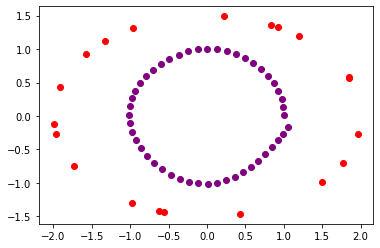

In [13]:
y = generate_observations(20)
z = generate_latent(48)
y1 = model(z)
plt.plot(y1[:,0].detach().numpy(), y1[:,1].detach().numpy(), 'o', color='purple');
plt.plot(y[:,0], y[:,1], 'o', color='red');

In [14]:
def energy_function(predicts, target):
    return (torch.sum(torch.pow(target - predicts, 2), dim=1))

torch.Size([48, 2])
tensor(17)


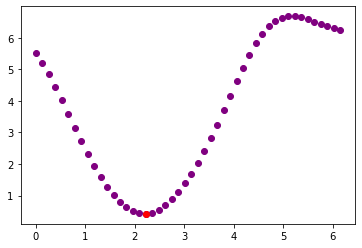

In [15]:
en = energy_function(y1, y[5])
print(y1.shape)
plt.plot(z, en.detach().numpy(), 'o', color='purple');
i = torch.argmin(en)
print(i)
plt.plot(z[i], en[i].detach().numpy(), 'o', color='red');

In [23]:
def generate_input_data(n):
    α = 1.5
    β = 2.0
    θ = (-2*math.pi)*torch.rand(n) + 2*math.pi
    x = torch.rand(n)
    
    x1 = α*x+β*(1-x)
    x2 = β*x+α*(1-x)
    x1 = x1*torch.exp(2*x)
    x2 = x2*torch.exp(2*x)
    
    y1 = x1*torch.sin(θ)
    y2 = x2*torch.cos(θ)
    
    return x, y1, y2

In [20]:
#The decoder is x1sin(z), x2cos(z)
class Simple_Predictor_Decoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(1,16),
            nn.ReLU(),
            nn.Linear(16,16),
            nn.ReLU(),
            nn.Linear(16,8),
            nn.Linear(8,2)
        )
    def forward(self,x,z):
        out = self.model(x)
        x1,x2 = torch.split(out, 1, dim=1)
        #print(x1.shape)
        return torch.cat([x1*torch.sin(z), x2*torch.cos(z)], dim=1)

In [21]:
#The decoder is x1sin(z), x2cos(z)
class Complex_Predictor_Decoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(1,16),
            nn.ReLU(),
            nn.Linear(16,16),
            nn.ReLU(),
            nn.Linear(16,8),
            nn.Linear(8,2)
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(2,10),
            nn.Tanh(),
            nn.Linear(10,2)
        )
        
        self.decoder_latent = nn.Sequential(
            nn.Linear(1,16),
            nn.Tanh(),
            nn.Linear(16,16),
            nn.Tanh(),
            nn.Linear(16,8),
            nn.Linear(8,1)
        )
        
    def forward(self,x,z):
        out = self.model(x)
        out = out+z
        out = self.decoder(out)
        #outz = self.decoder_latent(z)
        #out = out+outz
        x1,x2 = torch.split(out, 1, dim=1)
        #print(x1.shape)
        return torch.cat([x1, x2],dim=1)

In [52]:
model = Simple_Predictor_Decoder()
latent_variable = torch.tensor([5.0], requires_grad=True)
optimizer_latent =torch.optim.Adam([latent_variable],lr=0.01)
mse = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(),lr=0.05 )
x, y1, y2 = generate_input_data(500)
z = generate_latent(500)
x = x.unsqueeze(1)
obs = torch.cat([y1.unsqueeze(1), y2.unsqueeze(1)], dim=1)
bs=32

train_x = x
train_y = obs

In [53]:
#training
for _ in range(3):
    j=1
    for i in range(len(train_x)):
            with torch.no_grad():
                out = model(train_x[i].unsqueeze(1), z)
                en = energy_function(out, train_y[i])
                z_low = torch.argmin(en)
            
            optimizer.zero_grad()
            
            o = model(train_x[i].unsqueeze(1),z[z_low])
            
            loss = mse(o.squeeze(), train_y[i])
            loss.backward()
            optimizer.step()

In [54]:
pre_obs = model(train_x, z)

In [55]:
print(pre_obs.shape)

torch.Size([500, 2])


torch.Size([1000]) torch.Size([1000]) torch.Size([1000])


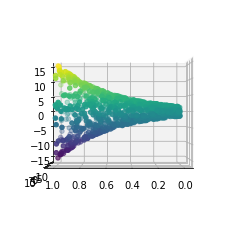

In [45]:
ax = plt.axes(projection='3d')
xd, yd, zd = generate_input_data(1000)
z = generate_latent(1000)
#ax.scatter3D(train_x.detach().numpy(), pre_obs[:,0].detach().numpy(), pre_obs[:,1].detach().numpy(),c=pre_obs[:,1].detach().numpy(), cmap='viridis');
print(xd.shape, yd.shape, zd.shape)
ax.scatter3D(xd, yd, zd,c=zd, cmap='viridis');
ax.view_init(0,90)

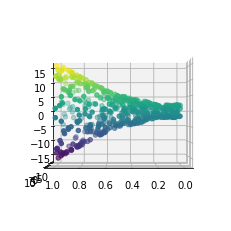

In [56]:
ax = plt.axes(projection='3d')


ax.scatter3D(train_x, pre_obs[:,0].detach().numpy(), pre_obs[:,1].detach().numpy(),c=pre_obs[:,1].detach().numpy(), cmap='viridis');
ax.view_init(0,90)

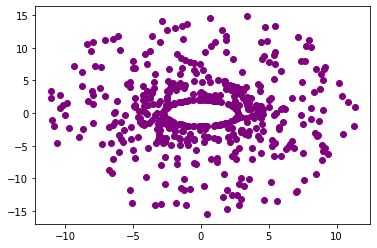

In [57]:
plt.plot(pre_obs[:,0].detach().numpy(), pre_obs[:,1].detach().numpy(), 'o', color='purple');

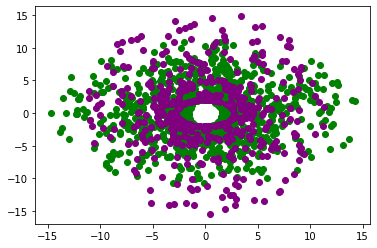

In [58]:
plt.plot(zd[:], yd[:], 'o', color='green');
plt.plot(pre_obs[:,0].detach().numpy(), pre_obs[:,1].detach().numpy(), 'o', color='purple');

In [59]:
torch.save(model, './out.pt')